## Imputations methods

In this notebook we are going to explore different imputation methods

For a more theoretical perspective consider http://www.stat.columbia.edu/~gelman/arm/missing.pdf

Also look at https://www.paultwin.com/wp-content/uploads/Lodder_1140873_Paper_Imputation.pdf

TODO: also take into account more complicated methods that directly tavkle the problem of classification such as BoostClean https://arxiv.org/pdf/1711.01299.pdf

For a more detail description check the book "Flexible imputationn of missing data" https://stefvanbuuren.name/fimd/

In out case the missingness of values is not random but can be an indicator by itself

First we need to define a little clearer the setting exactly. For startes we are going to deal with only the 5 most common diseases. Also for starters we are merely going to deal with classifying based on the first diagnosis given only. We are going to consider the multiclass classification problem first, but we are should also check the binary classification one to compare with established methods.

In [14]:
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

In [2]:
behaviour_data = pd.read_csv('DataScience2019_MRI/Behavioral/cleaned/HBNFinalSummaries.csv', low_memory=False)

behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]

keep_most_common_diseases = 5
most_common_disorders = behaviour_data['DX_01_Cat'].value_counts().keys().values[:keep_most_common_diseases]
behaviour_data = behaviour_data[behaviour_data['DX_01_Cat'].isin(most_common_disorders)]
behaviour_data = behaviour_data.reset_index(drop=True)

In [3]:
most_common_disorders

array(['Neurodevelopmental Disorders', 'No Diagnosis Given',
       'Anxiety Disorders', 'Depressive Disorders', 'Disruptive'],
      dtype=object)

In [4]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]
df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

Now we can safely remove previous columns describing diagnosis

In [5]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX')!=-1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [6]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

It is also reasonable to assume that we need to drop columns with too many Nans?

In [7]:
# threshold = 0.8

# columns_mask = pd.isnull(behaviour_data).sum() / behaviour_data.shape[0] > threshold

# print('Droping this many columns:', np.sum(columns_mask))

# dropped_columns = behaviour_data.columns[columns_mask]

# behaviour_data = behaviour_data.drop(columns=dropped_columns)
# behaviour_data = behaviour_data.reset_index(drop=True)

In [8]:
print('Shape', behaviour_data.shape)
behaviour_data.head(5)

Shape (1725, 311)


,Anonymized.ID,EID,Sex,Age,Study.Site,ACE_Score,APQ_P_OPD,APQ_P_Total,APQ_SR_OPD,APQ_SR_Total,...,YSR_RBB,YSR_SC,YSR_Ext,YSR_Int,YSR_Total,Neurodevelopmental Disorders,No Diagnosis Given,Anxiety Disorders,Depressive Disorders,Disruptive
0,A00078864,NDARYM832PX3,1,7.048254,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0
1,A00078865,NDARNJ687DMC,1,6.348163,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0
2,A00078866,NDARRM363BXZ,0,10.052589,1,NaN,NaN,NaN,17.0,118.0,...,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0
3,A00078867,NDARUW586LLL,1,12.319415,1,NaN,NaN,NaN,NaN,NaN,...,7.0,9.0,16.0,29.0,85.0,0,0,0,1,0
4,A00078868,NDARDC298NW4,0,13.901437,1,NaN,NaN,NaN,33.0,154.0,...,2.0,11.0,10.0,26.0,70.0,1,0,0,0,0


We are going to explore some different imputation methods. More specifically:
1. Do nothing
2. Fill all missing values with a dummy value
3. Imputation Using (Mean/Median/Most Frequent) Values
4. Imputation Using k-NN, Randomforest
5. MICE (TODO)
6. Multiple imputer
7. Add features based on whether the value exists or not

For a comparison with a more naive baseline check out @gvasilako 's notebook for both multilabel and per class metrics

In [9]:
import sys
import xgboost as xgb
from missingpy import KNNImputer, MissForest
from impyute.imputation.cs import fast_knn
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning

In [10]:
# fdx and mdx may contain 'No Diagnosis'
# drop them for now but they may be important
# they correspond to father's and mother's primary diagnosis
columns_to_drop = ['Anonymized.ID', 'EID', 'mdx', 'fdx', 'fcodxm_1', 'fcodxm_2', 'fcodxm_3', 'mcodxm_1',
                   'mcodxm_2', 'mcodxm_3', 'mcodxmdt', 'TOWRE_Total_Desc', 'Picture_Vocab_Raw',
                   'sib1dx', 'sib1codxm_1', 'sib1codxm_2', 'sib1codxm_3',
                   'sib2dx', 'sib2codxm_1', 'sib2codxm_2', 'sib2codxm_3',
                   'sib3dx', 'sib3codxm_1', 'sib3codxm_2', 'sib3codxm_3',
                   'sib4dx', 'sib4codxm_1', 'sib4codxm_2', 'sib4codxm_3',
                   'sib5dx', 'sib5codxm_1', 'sib5codxm_2', 'sib5codxm_3']

processed = behaviour_data.drop(columns=columns_to_drop)
most_common_disorders = list(most_common_disorders)

In [11]:
def run_binary_classification(dataset, diseases_to_run_for, clf, imputer, imputer_requires_disorder, *args):
    for check_disorder in most_common_disorders[:diseases_to_run_for]:
        
        pos = most_common_disorders.index(check_disorder)

        columns_to_drop = most_common_disorders[:pos] + most_common_disorders[(pos + 1):]
        temp = dataset.drop(columns=columns_to_drop)

        train, test = train_test_split(temp, test_size=0.3, random_state=17)
        
        if imputer_requires_disorder:
            train, test = imputer(train, test, check_disorder, *args)
        else:
            train, test = imputer(train, test, *args)

        clf.fit(train.drop(columns=[check_disorder]), train[check_disorder])
        preds = clf.predict(test.drop(columns=[check_disorder]))
        y_test = test[check_disorder]

        print('================================= {0} ================================='.format(check_disorder))

        precision, recall, _, _ = precision_recall_fscore_support(y_test, preds)
        accuracy = accuracy_score(y_test, preds)

        print('accuracy {:.3f} precision {:.3f} {:.3f} recall {:.3f} {:.3f}' \
              .format(accuracy, precision[0], precision[1], recall[0], recall[1]))

        print(confusion_matrix(y_test, preds))

Before actually droping columns that cannot be incorporated for the next analysis as they are categorical values, we should check their correlation with the predicted classes!

In [12]:
disorder_corr = np.zeros((len(columns_to_drop) - 2, len(most_common_disorders)))

# the disorder to find the correlation for
for index, disorder in enumerate(most_common_disorders):
    dropped_columns_dataset = behaviour_data[columns_to_drop + [most_common_disorders[index]]]

    # remove the anonymized id and the EID
    for col in dropped_columns_dataset[2:-1]:
        dropped_columns_dataset[col] = dropped_columns_dataset[col].astype('category').cat.codes

    disorder_corr[:, index] = dropped_columns_dataset[dropped_columns_dataset.columns[2:]].corr()[most_common_disorders[index]][:-1].values

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


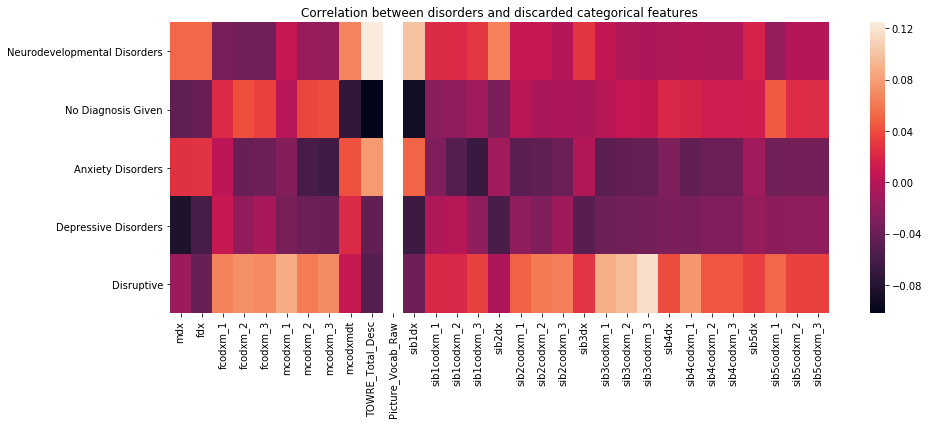

In [20]:
correlation_df = pd.DataFrame(disorder_corr.T, columns=columns_to_drop[2:], index=most_common_disorders)
sns.heatmap(correlation_df)

plt.title('Correlation between disorders and discarded categorical features')
plt.ylim([5, 0])
plt.tight_layout()

plt.show()

### 1st approach: Do nothing

Some algorithms such as XGBoost

In [102]:
def do_nothing(x, y):
    return x, y

run_binary_classification(processed, 1, xgb.XGBClassifier(), do_nothing, False)

================================= Neurodevelopmental Disorders =================================
accuracy 0.819 precision 0.657 0.858 recall 0.532 0.911
[[ 67  59]
 [ 35 357]]


### 2nd approach: Fill all missing values with a dummy value 

(For this refer to @gvasilak 's notebook)

### 3rd approach: Imputation Using (Mean/Median/Most_frequent) Values

In [109]:
strategy = 'median'
assert strategy in ['mean', 'median', 'most_frequent']

def imputer(x, y, strategy):
    if strategy == 'mean':
        filling = x.mean()
    elif strategy == 'median':
        filling = x.median()
    elif strategy == 'most_frequent':
        filling = x.mode().iloc[0]
    
    return x.fillna(filling), y.fillna(filling)

clf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
run_binary_classification(processed, 1, clf, imputer, False, strategy)

================================= Neurodevelopmental Disorders =================================
accuracy 0.807 precision 0.681 0.827 recall 0.389 0.941
[[ 49  77]
 [ 23 369]]


### 4th approach: Imputation Using k-NN

The algorithm uses ‘feature similarity’ to predict the values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set. 

In [141]:
# The missingpy algorithms to work require that not columsn have more than 80% missing values

threshold = 0.8

columns_mask = pd.isnull(processed).sum() / processed.shape[0] > threshold

print('Droping this many columns:', np.sum(columns_mask))

dropped_columns = processed.columns[columns_mask]

processed_80 = processed.drop(columns=dropped_columns)
processed_80 = processed_80.reset_index(drop=True)

Droping this many columns: 95


In [143]:
def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)

    x[x.columns] = x_new
    y[y.columns] = y_new
    return x, y

my_inputer = KNNImputer(n_neighbors=5, weights="distance")

run_binary_classification(processed_80, 1, clf, imputer_fun, False, my_inputer)

/home/sotiris/.local/lib/python3.7/site-packages/missingpy/knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
/home/sotiris/.local/lib/python3.7/site-packages/missingpy/knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/home/sotiris/.local/lib/python3.7/site-pa

================================= Neurodevelopmental Disorders =================================
accuracy 0.826 precision 0.737 0.842 recall 0.444 0.949
[[ 56  70]
 [ 20 372]]


In [ ]:
def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)

    x[x.columns] = x_new
    y[y.columns] = y_new
    return x, y

my_inputer = MissForest(max_depth=4)

run_binary_classification(processed_80, 1, clf, imputer_fun, False, my_inputer)

### 5th approach: MICE

In [ ]:
from fancyimpute import MICE as MICE



## 6th approach: Multiple imputer

In [ ]:
from autoimpute.imputations import SingleImputer, MultipleImputer

def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)
    
    return x_new, y_new


si = SingleImputer() # imputation methods, passing through the data once
mi = MultipleImputer() # imputation methods, passing through the data multiple times

run_binary_classification(processed, 1, clf, imputer_fun, False, mi)

### 7th approach: Add features indicating if the value os misisng or not

For this part we should take into account which exact features can have Nan values

The features that do not take any null values are 'Sex', 'Age', 'Study.Site' and the disorder we are currently checking for

In [139]:
def process_dataset(x, cols):
    x1 = x.drop(columns=cols).isna().astype('int32')
    
    # change column naming to enable the inner join
    x1.columns = [col + '_existence' for col in x1.columns]
    return x1.join(x)

def data_and_existence_of_features(x, y, disorder):
    cols = ['Sex', 'Age', 'Study.Site', disorder]
    rest_of_columns = list(x.columns.values)
    for c in cols:
        rest_of_columns.remove(c)
    
    x_new = process_dataset(x, cols)
    y_new = process_dataset(y, cols)
    
    x_new[rest_of_columns], y_new[rest_of_columns] = imputer(x_new[rest_of_columns], 
                                                             y_new[rest_of_columns], 
                                                             'most_frequent')
    return x_new, y_new

run_binary_classification(processed, 1, clf, data_and_existence_of_features, True)

================================= Neurodevelopmental Disorders =================================
accuracy 0.820 precision 0.739 0.833 recall 0.405 0.954
[[ 51  75]
 [ 18 374]]


## Existence of features

To explore the severity of existence of a feature for the correct classification, we only try to predict based on the existence of the features only and not the actual value

In [118]:
def process_dataset_only_existence(x, cols):
    x1 = x.drop(columns=cols).isna().astype('int32')
    x2 = x[cols]
    
    return x1.join(x2)

def only_existence_of_features(x, y, disorder):
    cols = ['Sex', 'Age', 'Study.Site', disorder]
    return process_dataset_only_existence(x, cols), process_dataset_only_existence(y, cols)

run_binary_classification(processed, 1, clf, only_existence_of_features, True)

================================= Neurodevelopmental Disorders =================================
accuracy 0.720 precision 0.398 0.791 recall 0.294 0.857
[[ 37  89]
 [ 56 336]]
